## Let's import the stuff we need in this notebook

In [103]:
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 

## Let's define two data distributions in 2d
These functions generate two distributions of points with 2d coordinates. 

In [369]:
def distrib1(n):
    x = np.random.rand(n,2)-0.5
    x[:,1] = 0.4 - 0.2*x[:,0] - 0.3*np.cos(6*np.pi*x[:,0]) + 0.1*np.random.randn(n) -(np.random.randn(n)<0)*0.8
    return x

def distrib2(n):
    x = np.random.rand(n,2)-0.5
    x[:,1] = - 0.2*x[:,0] - 0.3*np.cos(6*np.pi*x[:,0]) + 0.05*np.random.randn(n)
    return x


## Training samples and their visualization
Lets sample n examples from the two distributions and visualize them. The task of our classification network will be to predict the membership to one of the classes for given 2d coordinates of a point. 

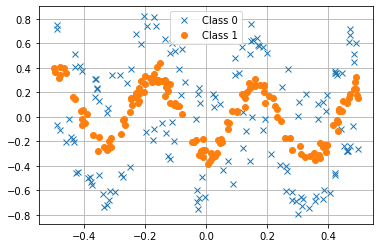

In [380]:
n = 150
x1 = distrib1(n)
x2 = distrib2(n)

plt.plot(x1[:,0],x1[:,1], 'x', label='Class 0')
plt.plot(x2[:,0],x2[:,1], 'o', label='Class 1')
plt.legend()
plt.grid()
plt.show()

Xtrain = np.concatenate((x1,x2),axis=0)
Ytrain = np.ones((2*n))
Ytrain[0:n] = 0

## Let's define a simple (fully connected) network

In [381]:
# Lets define a network architecture
class myNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        d_hidden = 40
        self.fc1 = nn.Linear(2, d_hidden)
        self.fc2 = nn.Linear(d_hidden,d_hidden)
        self.fc3 = nn.Linear(d_hidden,2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
        

## And train the network

In [382]:
## Lets create a network instance and train it
model = myNet()

Xtrain_PT = torch.from_numpy(Xtrain).type(torch.FloatTensor)
Ytrain_PT = torch.from_numpy(Ytrain).type(torch.LongTensor)

# training
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(10000):
    y_pred = model(Xtrain_PT)
    loss = criterion(y_pred, Ytrain_PT)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if np.mod(epoch,1000)==0:
            print(epoch, loss.item())

0 0.6983494162559509
1000 0.05854799225926399
2000 0.04337790235877037
3000 0.020131343975663185
4000 0.008960988372564316
5000 0.0037748320028185844
6000 0.0014495785580947995
7000 0.0006240051006898284
8000 0.00029021690716035664
9000 0.00014256566646508873


## Visualization of the result
A nice way to visualize the predictions of a network in such a simple 2d example is to feed an entire meshgrid of coordinates (i.e. a dense sampling of the 2d plane) into the network, and visualize the predictions via a contour plot  

#### What is a meshgrid?

In [383]:
x = torch.linspace(-1,1,5)
print(x)
grid_y, grid_x = torch.meshgrid(x, x)
print(grid_y)

tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])
tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-0.5000, -0.5000, -0.5000, -0.5000, -0.5000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.5000,  0.5000,  0.5000,  0.5000,  0.5000],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000]])


#### The visualization function

In [384]:
def visualizeMyDecisionBoundary(model):
    c=100
    x = torch.linspace(-0.7,0.7,c)
    y = torch.linspace(-0.9,0.9,c)
    grid_y, grid_x = torch.meshgrid(x, y)
    wholeGrid = torch.cat((torch.reshape(grid_y, (-1,1)), torch.reshape(grid_x, (-1,1))), 1)
    
    probs = F.softmax(model(wholeGrid),dim=1) # Predicted probabilities for each point on the grid
    
    decisionBoundary = torch.reshape(probs[:,0], (c,c)) # Reshape into an image
    plt.contourf(grid_y.detach().numpy() , grid_x.detach().numpy() , decisionBoundary.detach().numpy(),np.linspace(0,1,10),cmap=plt.cm.bone)

    plt.plot(x1[:,0],x1[:,1], 'x', label='Class 0')
    plt.plot(x2[:,0],x2[:,1], 'o', label='Class 1')
    plt.legend()
    plt.grid()

    

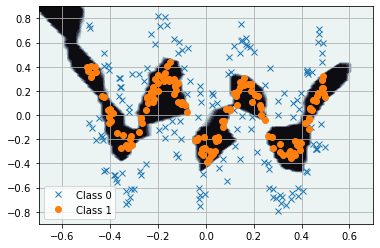

In [385]:
visualizeMyDecisionBoundary(model)

## Now let us define the label smoothing loss ...

In [386]:
class LabelSmoothingLoss(nn.Module):
    
    def __init__(self, smoothing=0.0):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, prediction, target):
        assert 0 <= self.smoothing < 1
        neglog_softmaxPrediction = -prediction.log_softmax(dim=1)

        with torch.no_grad():
            smoothedLabels = self.smoothing / (prediction.size(1) - 1)* torch.ones_like(prediction)
            smoothedLabels.scatter_(1, target.data.unsqueeze(1), 1-self.smoothing)
        return torch.mean(torch.sum(smoothedLabels * neglog_softmaxPrediction, dim=1)) 

## ... and train a network with it

In [387]:
## Lets create a network instance and train it
modelLS = myNet()

Xtrain_PT = torch.from_numpy(Xtrain).type(torch.FloatTensor)
Ytrain_PT = torch.from_numpy(Ytrain).type(torch.LongTensor)

# training
criterion = LabelSmoothingLoss(smoothing=0.1)   #<<<< This is the only line that changed!! 
learning_rate = 1e-2
optimizer = torch.optim.Adam(modelLS.parameters(), lr=learning_rate)
for epoch in range(10000):
    y_pred = modelLS(Xtrain_PT)
    loss = criterion(y_pred, Ytrain_PT)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if np.mod(epoch,1000)==0:
            print(epoch, loss.item())
            

0 0.6919335722923279
1000 0.36140361428260803
2000 0.3480610251426697
3000 0.3455781936645508
4000 0.34374168515205383
5000 0.34149035811424255
6000 0.33879518508911133
7000 0.3394621014595032
8000 0.39475369453430176
9000 0.33650627732276917


## Let's visualize the decision boundary of the network trained with label smoothing

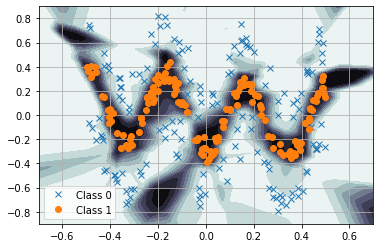

In [388]:
visualizeMyDecisionBoundary(modelLS)

##### Reminder - this was the original decision boundary

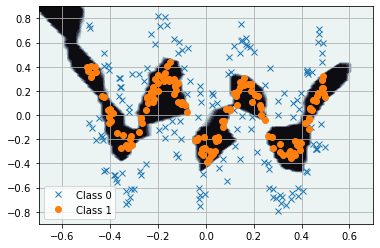

In [389]:
visualizeMyDecisionBoundary(model)

## Let's play with Maxup!

In [390]:
## Implementation inspired by https://github.com/JonasGeiping/data-poisoning/
# see forest / data / mixing_data_augmentations.py

class Maxup(torch.nn.Module):
    """A meta-augmentation, returning the worst result from a range of augmentations.
    As in the orignal paper, https://arxiv.org/abs/2002.09024,
    """

    def __init__(self, given_data_augmentation, ntrials=4):
        """Initialize with a given data augmentation module."""
        super().__init__()
        self.augment = given_data_augmentation
        self.ntrials = ntrials
        self.max_criterion = torch.nn.CrossEntropyLoss(reduction='none')

    def forward(self, x, y):
        additional_x, additional_labels = [], []
        for trial in range(self.ntrials):
            x_out, y_out = self.augment(x, y)
            additional_x.append(x_out)
            additional_labels.append(y_out)

        additional_x = torch.cat(additional_x, dim=0)
        additional_labels = torch.cat(additional_labels, dim=0)
        
        return additional_x, additional_labels


    def maxup_loss(self, outputs, extra_labels):
        """Compute loss. Here the loss is computed as worst-case estimate over the trials."""
        batch_size = outputs.shape[0] // self.ntrials
        correct_preds = (torch.argmax(outputs.data, dim=1) == extra_labels).sum().item() / self.ntrials
        stacked_loss = self.max_criterion(outputs, extra_labels).view(batch_size, self.ntrials, -1)
        loss = stacked_loss.max(dim=1)[0].mean()
        
        return loss, correct_preds

In [441]:
def myNoiseAdditionAugmenter(x,y):
    sigma = 0.03
    return x + sigma*torch.randn_like(x), y

### Let's try our maxup implementation out in training

In [442]:
## Lets create a network instance and train it
modelMaxup = myNet()


Xtrain_PT = torch.from_numpy(Xtrain).type(torch.FloatTensor)
Ytrain_PT = torch.from_numpy(Ytrain).type(torch.LongTensor)

# training
maxup = Maxup(myNoiseAdditionAugmenter, ntrials=2)
learning_rate = 1e-2
optimizer = torch.optim.Adam(modelMaxup.parameters(), lr=learning_rate)
for epoch in range(10000):
    
    inputs,targets = maxup(Xtrain_PT.detach().clone(),Ytrain_PT.detach().clone())
    y_pred = modelMaxup(inputs)
    loss = maxup.maxup_loss(y_pred, targets.long())[0]
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if np.mod(epoch,1000)==0:
            print(epoch, loss.item())
            

0 0.698596179485321
1000 0.44221970438957214
2000 0.36278507113456726
3000 0.31801214814186096
4000 0.3353959023952484
5000 0.3857899606227875
6000 0.35805386304855347
7000 0.32909488677978516
8000 0.3789203464984894
9000 0.37370505928993225


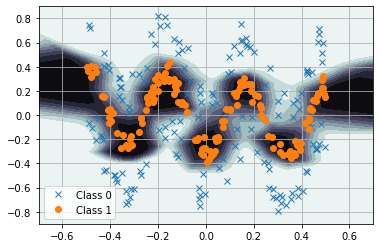

In [443]:
visualizeMyDecisionBoundary(modelMaxup)